In [2]:
#Modules used in the Project
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import itertools
import seaborn as sns
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

def load_datasets():
  data_train = np.load('/content/drive/MyDrive/Colab Notebooks/data_train.npy') #loading the data from npy file
  labels_train = np.load('/content/drive/MyDrive/Colab Notebooks/labels_train.npy') #loading labels form npy file
  #print(data_train.shape, labels_train.shape)
  return data_train, labels_train

In [5]:
def preprocess_data(data_train):
  #reshaping the original  90,000 x 1 to a 300 x 300 then to 30 X 30 size.
  resize_image_size = 30
  resized_dataset = []#list to store the resized samples
  for i in range(data_train.shape[1]):# range of 90,000 per digit for 3360 digits
      single_image = data_train[:,i]# each image is made up of 90,000 pixels
      single_image = single_image.reshape(300,300)# reshaping the original image from 90,000 x 1 to a 300 x 300
      resizing_dim = (resize_image_size,resize_image_size)
      resized_image = cv2.resize(single_image, resizing_dim, interpolation = cv2.INTER_AREA)# For the interpolation, we use INTER_AREA: which resamples using pixel area relation. It may be a preferred method of image decimation, as it gives more free results. But when the image is zoomed out, it is similar to the INTER_NEAREST method
      resized_image = resized_image.reshape(resize_image_size*resize_image_size)
      
      resized_dataset.append(resized_image)
  resized_dataset_array = np.array(resized_dataset)
  #print(resized_dataset_array.shape)
  data_resized = np.array(resized_dataset).T

  #Morphological transformation of closing operation
  # closing of resized (30x30) dataset
  closing_resized_dataset = []#list to store the closing resized samples
  for i in range(data_resized.shape[1]): 
      single_image = data_resized[:,i] #taking each column -> each image
      kernel = np.ones((1,1),np.uint8) #kernal of size 1x1 pixel(optimum for resized dataset)
      closing_image = cv2.morphologyEx(single_image,cv2.MORPH_CLOSE,kernel)
      closing_resized_dataset.append(closing_image)
  closing_resized_dataset_array = np.array(closing_resized_dataset)
  data_closing = np.array(closing_resized_dataset).T
  data_closing= data_closing.squeeze()

  return data_closing


In [6]:
def partition_normalize_data(preprocessed_data,labels_train):
  resize_image_size = 30
  #partitioning the data into train and test dataset(which is partitioning the train data into 80%-train, 20%-validation)
  X_train, X_test, y_train, y_test = train_test_split(preprocessed_data.T, labels_train, test_size=0.2,random_state=0)
  display_data(y_train,X_train)
  X_train = X_train.reshape(X_train.shape[0], resize_image_size, resize_image_size, 1)
  X_test = X_test.reshape(X_test.shape[0], resize_image_size, resize_image_size, 1)
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')  
  #normalizing the data
  X_train/=255.0
  X_test/=255.0
  #adding an extra channel which i compatable size for the sequential model.
  number_of_classes = 10
  Y_train = np_utils.to_categorical(y_train, number_of_classes)
  Y_test = np_utils.to_categorical(y_test, number_of_classes)
  #shapes after splitting and normalizing
  # X_train-(2688, 30, 30, 1)
  #X_test-(672, 30, 30, 1)
  #Y_train-(2688, 10)
  #Y_test-(672, 10)
  return X_train, X_test,Y_train,Y_test

In [7]:
def display_data(y_train,x_train):
  # Counting number samples per class
  vals, counts = np.unique(y_train, return_counts=True)
  plt.bar(vals, counts)
  plt.xticks(range(10),range(10))
  plt.xlabel('Digits/Classes',size=20)
  plt.ylabel('# Samples per Class', size=20)
  plt.title('Training Data (Total = '+str(x_train.shape[0])+' samples)',size=15);

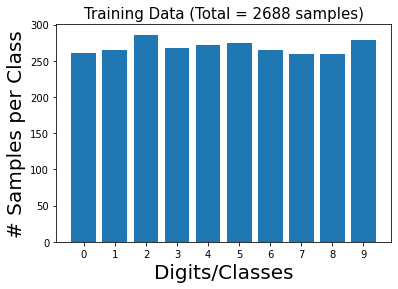

In [8]:
data, labels = load_datasets()
preprocessed_data = preprocess_data(data)
X_train, X_test,Y_train,Y_test = partition_normalize_data(preprocessed_data,labels)


In [10]:
def cnn_model1(X_train,X_test):
# Three steps to Convolution
# 1. Convolution
# 2. Activation
# 3. Polling
# Repeat Steps 1,2,3 for adding more hidden layers
# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN to classify the samples
  kernal_size = (3,3)
  batch_size=64
  epochs =150
  image_width_height = 30
  model = Sequential()

  model.add(Conv2D(32, kernal_size, input_shape=(30,30,1)))
  model.add(Activation('relu'))
  BatchNormalization(axis=-1)
  model.add(Conv2D(32, kernal_size))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  BatchNormalization(axis=-1)
  model.add(Conv2D(64,kernal_size))
  model.add(Activation('relu'))
  BatchNormalization(axis=-1)
  model.add(Conv2D(64, kernal_size))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  # Fully connected layer

  BatchNormalization()
  model.add(Dense(512))
  model.add(Activation('relu'))
  BatchNormalization()
  model.add(Dropout(0.2))
  model.add(Dense(10))

  model.add(Activation('softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0004), metrics=['accuracy'])
  #data augmentation
  gen = ImageDataGenerator(rotation_range=8, 
                           width_shift_range=0.08, 
                           shear_range=0.3,
                           height_shift_range=0.08, 
                           zoom_range=0.08)
  
  test_gen = ImageDataGenerator()
  train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
  test_generator = test_gen.flow(X_test, Y_test, batch_size=batch_size)

  jpgs_model = model.fit_generator(train_generator, steps_per_epoch=X_train.shape[0]//batch_size, epochs=epochs, 
                    validation_data=test_generator, validation_steps=X_test.shape[0]//batch_size)
  
  model.save('JPGS_Final_Model1.h5')

  return model, jpgs_model

In [11]:
def cnn_model(X_train,X_test):
# Three steps to Convolution
# 1. Convolution
# 2. Activation
# 3. Polling
# Repeat Steps 1,2,3 for adding more hidden layers
# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN to classify the samples
  kernal_size = (3,3)
  batch_size=64
  epochs =150
  image_width_height = 30
  model = Sequential()

  model.add(Conv2D(32, kernal_size, input_shape=(image_width_height,image_width_height,1)))
  model.add(Activation('relu'))
  model.add(BatchNormalization(axis=-1))
  model.add(Conv2D(32, kernal_size))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(BatchNormalization(axis=-1))
  model.add(Conv2D(64,kernal_size))
  model.add(Activation('relu'))
  model.add(BatchNormalization(axis=-1))
  model.add(Conv2D(64, kernal_size))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  # Fully connected layer

  model.add(BatchNormalization())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(10))

  # model.add(Convolution2D(10,3,3, border_mode='same'))
  # model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  #data augmentation
  gen = ImageDataGenerator(rotation_range=8, 
                           width_shift_range=0.08, 
                           shear_range=0.03,
                           height_shift_range=0.08, 
                           zoom_range=0.08)
  
  test_gen = ImageDataGenerator()
  train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
  test_generator = test_gen.flow(X_test, Y_test, batch_size=batch_size)

  jpgs_model = model.fit_generator(train_generator, steps_per_epoch=X_train.shape[0]//batch_size, epochs=epochs, 
                    validation_data=test_generator, validation_steps=X_test.shape[0]//batch_size)
  
  model.save('JPGS_Final_Model.h5')

  return model, jpgs_model

In [17]:
def get_accuracy(model,X_train, X_test,Y_train,Y_test):
  loss, accuracy = model.evaluate(X_test, Y_test)
  loss_v, accuracy_v = model.evaluate(X_train, Y_train)
  print("train: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
  print("Test: accuracy = %f  ;  loss = %f" % (accuracy*100, loss*100))

In [13]:
model, jpgs_model=cnn_model1(X_train,X_test)
get_accuracy(model,X_train, X_test,Y_train,Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0

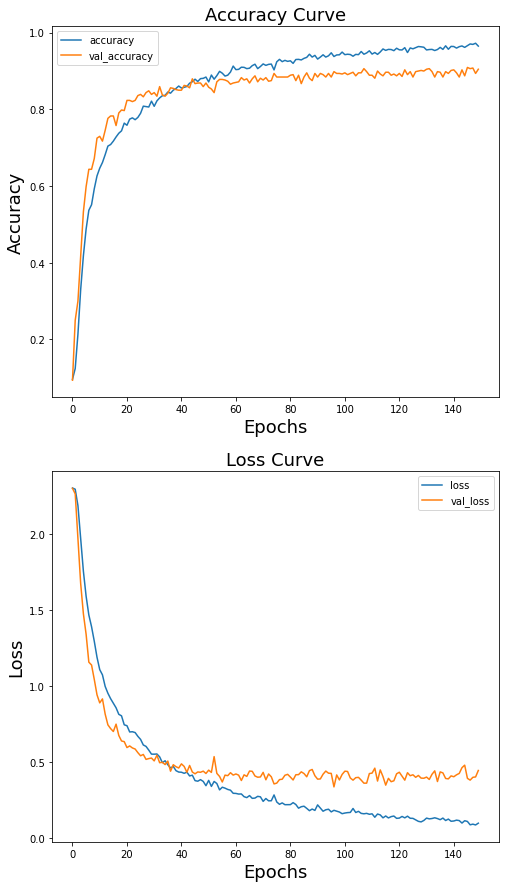

In [15]:
#Plotting The Corresponding Accuracy Curve and Loss Curve
f = plt.figure(figsize=(8,15))

f.add_subplot(211)

plt.plot(jpgs_model.epoch,jpgs_model.history['accuracy'],label = "accuracy")                 # Accuracy curve for training set
plt.plot(jpgs_model.epoch,jpgs_model.history['val_accuracy'],label = "val_accuracy")         # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Accuracy",fontsize=18)
#plt.grid(alpha=0.5)
plt.legend()

f.add_subplot(212)

plt.plot(jpgs_model.epoch,jpgs_model.history['loss'],label="loss")                           # Loss curve for training set
plt.plot(jpgs_model.epoch,jpgs_model.history['val_loss'],label="val_loss")                   # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Loss",fontsize=18)
#plt.grid(alpha=0.5)
plt.legend()

plt.show()


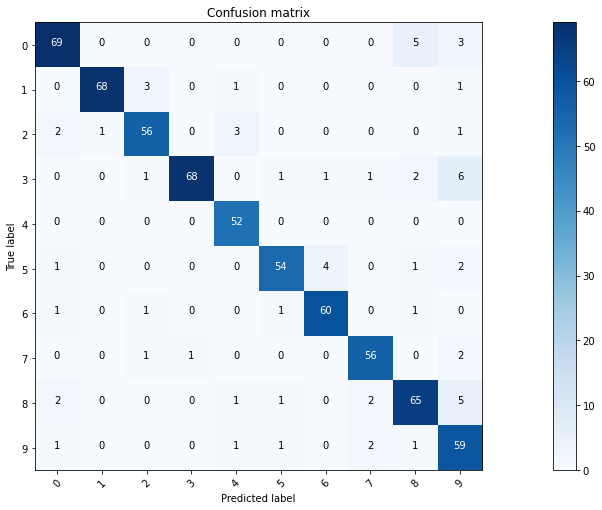

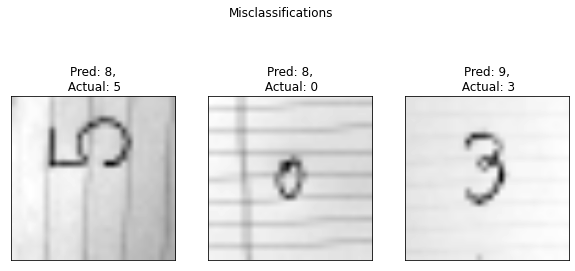

In [16]:
# Now, we are Plotting the Confusion Matrix of our tested dataset

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(20,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predicted values
Y_pred = model.predict(X_test)
# Predictions -> one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Validations -> one hot vectors
y_test = np.argmax(Y_test,axis = 1)

# Computing The dataset for our confusion matrix & Plotting it
confusion_matrix_result = confusion_matrix(y_test, Y_pred_classes)
plot_confusion_matrix(confusion_matrix_result, classes = range(10)) 

#getting correct and misclassification results
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
index = 0
misclassified_images = []
for label, predict in zip(y_test, Y_pred_classes):
    if label != predict: 
        misclassified_images.append(index)
    index +=1
correctclassified_images = []
for label, predict in zip(y_test, Y_pred_classes):
    if label == predict: 
        correctclassified_images.append(index)
    index +=1


#plotting misclassification results
plt.figure(figsize=(10,5))
plt.suptitle('Misclassifications');

for plot_index, bad_index in enumerate(misclassified_images[0:3]):
    #print(plot_index)
    p = plt.subplot(1,3, plot_index+1) # 1x3 plot -> 3 misclassified images
    
    p.imshow(X_test[bad_index].reshape(30,30), cmap=plt.cm.gray,
            interpolation='bilinear')
    p.set_xticks(()); p.set_yticks(()) # remove ticks
    
    p.set_title(f'Pred: {Y_pred_classes[bad_index]},\n Actual: {y_test[bad_index]}');


    